In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [47]:
data = pd.read_csv("DataAssignment3.csv")


data["NumberWordsTrans"] = np.log(data.NumberWords)
data.NumberWordsTrans += -2*np.roll(data.NumberWordsTrans, 1, axis=0) + np.roll(data.NumberWordsTrans, 2, axis=0)
# np.roll(data, 1, axis=0)
data = pd.get_dummies(data)
data    

,Date,NumberWords,NumberWordsTrans,Government_Conservative,Government_Independent,Government_Social Democrats,Government_Social Liberals,Government_Venstre
0,1919,156684,-5.312076,0,0,0,1,0
1,1920,170624,5.367485,0,0,0,0,1
2,1921,173917,-0.066115,0,0,0,0,1
3,1922,190745,0.073243,0,0,0,0,1
4,1923,192954,-0.080845,0,0,0,0,1
...,...,...,...,...,...,...,...,...
97,2016,26999144,0.058232,0,0,0,0,1
98,2017,27356201,-0.028163,0,0,0,0,1
99,2018,29523506,0.063105,0,0,0,0,1
100,2019,29931409,-0.062522,0,0,1,0,0


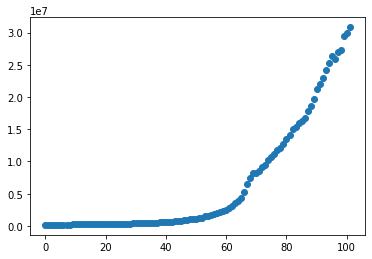

In [40]:
plt.scatter(range(len(data.NumberWords)), data.NumberWords)

In [13]:
# data loader
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.len = len(data)
    def __getitem__(self, index):
        x = torch.tensor(self.data.iloc[index][1:].values)
        y = torch.tensor(self.data.iloc[index+1][1]) if index < self.len-1 else torch.tensor(np.NaN)
        return x, y
    def __len__(self):
        return self.len

dataloader = DataLoader(Dataset(data), batch_size=2, shuffle=False)

# lstm for predicting NumberWords in data
import torch.nn as nn
import torch.nn.functional as F

for x, y in dataloader:
    print(x, y)
    break


tensor([[156684,      0,      0,      0,      1,      0],
        [170624,      0,      0,      0,      0,      1]]) tensor([170624, 173917])


In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # x = x.unsqueeze(0).float()
        x, _ = self.lstm(x.view(1,2, -1))
        x = self.linear(x)
        return x


model = LSTM(input_size=6, hidden_size=10, output_size=1)

# train model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1):
    for i, (x, y) in enumerate(dataloader):
        print(x.size())
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("loss = ", loss.item())

torch.Size([2, 6])


RuntimeError: expected scalar type Long but found Float